# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from pycirclize import Circos

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



# Smetana (Chord Diagram Construction)

/tmp/ipykernel_8720/3718118743.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(strains))


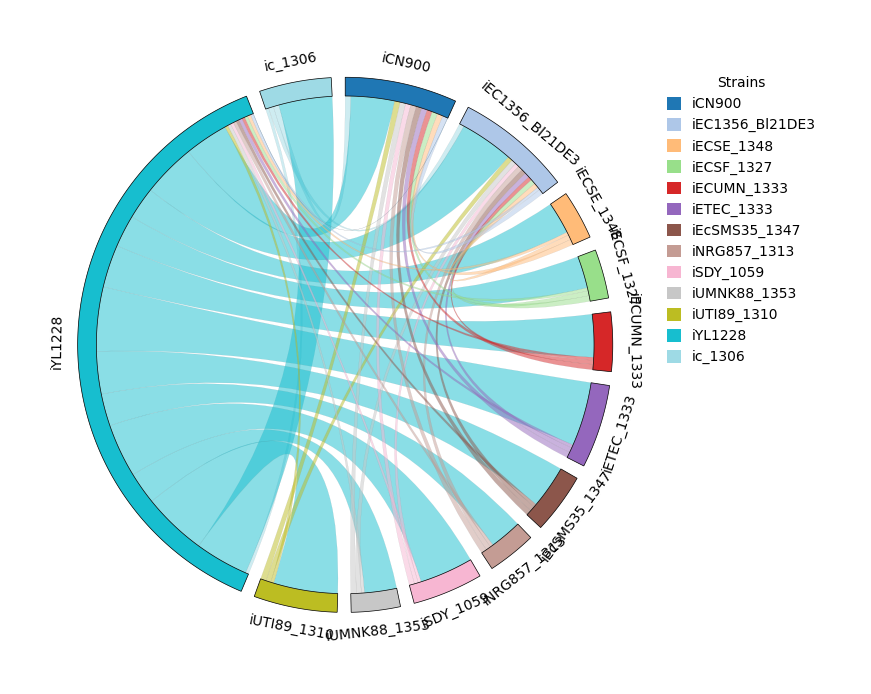

In [ ]:
# Load and build the matrix
df = pd.read_csv("/home/arog/Documents/GitHub/HGMB_Project/comm_results/smetana_all_detailed.tsv", sep="\t")
strains = sorted(set(df["donor"]).union(set(df["receiver"])))
matrix_df = pd.DataFrame(0.0, index=strains, columns=strains)
for _, row in df.iterrows():
    matrix_df.loc[row["donor"], row["receiver"]] += row["smetana"]

# Generate color map and assign a color to each strain
cmap = cm.get_cmap("tab20", len(strains))
colors = {strain: cmap(i) for i, strain in enumerate(strains)}

# Build chord diagram with no labels
circos = Circos.chord_diagram(
    matrix_df,
    space=3,
    r_lim=(93, 100),
    cmap=colors,
    label_kws=None
)

# Plot chord diagram
fig = circos.plotfig()

# Add custom legend
legend_handles = [mpatches.Patch(color=colors[strain], label=strain) for strain in matrix_df.index]
plt.legend(handles=legend_handles, title="Strains", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)

plt.tight_layout()
plt.show()

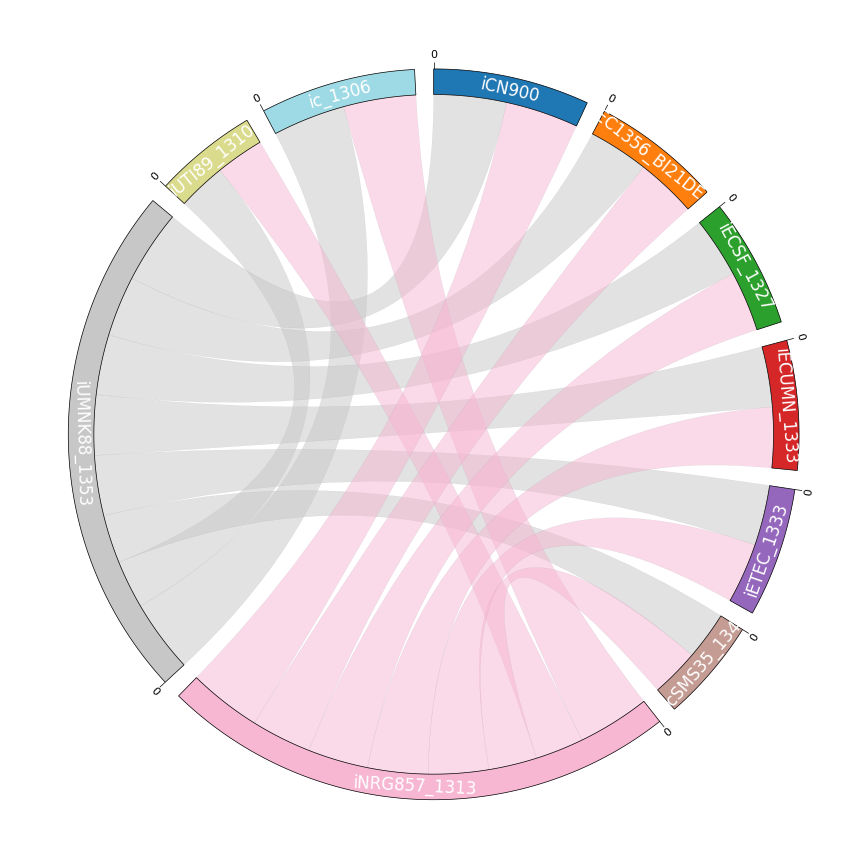

In [ ]:
# Load SMETANA detailed-mode TSV file
df = pd.read_csv("/home/arog/Documents/GitHub/HGMB_Project/comm_results/smetana_healthy_detailed.tsv", sep="\t")

# Get unique strains from donor + receiver
strains = sorted(set(df["donor"]).union(set(df["receiver"])))

# Initialize empty matrix (donor = rows, receiver = columns)
matrix_df = pd.DataFrame(0.0, index=strains, columns=strains)

# Fill matrix with summed SMETANA scores
for _, row in df.iterrows():
    donor = row["donor"]
    receiver = row["receiver"]
    score = row["smetana"]
    matrix_df.loc[donor, receiver] += score

# Build chord diagram with the template style
circos = Circos.chord_diagram(
    matrix_df,
    space=3,
    r_lim=(93, 100),
    cmap="tab20",  # more distinct colors
    ticks_interval=500,
    label_kws=dict(r=94, size=12, color="white")
)

# Plot and show
fig = circos.plotfig()
plt.show()

# Micom 

# Strain Fluxes Distribution Analysis

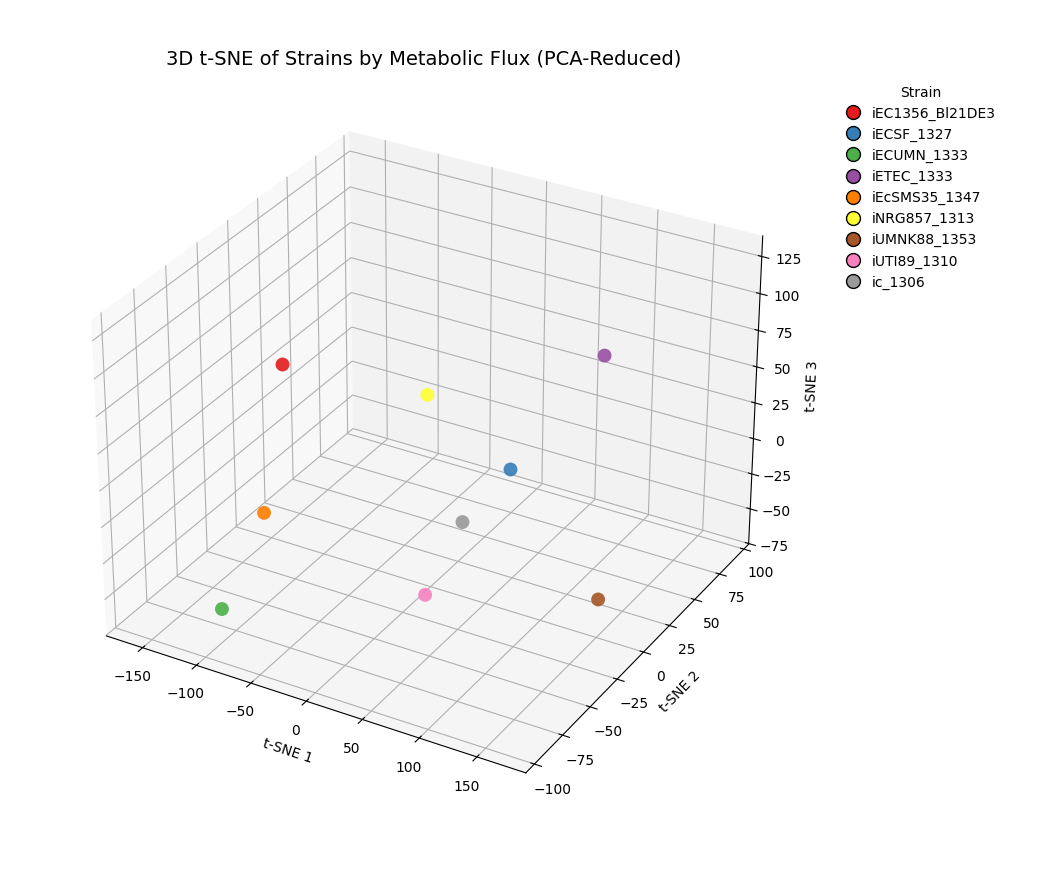

In [ ]:
df = pd.read_csv("/home/arog/Documents/GitHub/HGMB_Project/comm_results/fluxes_MICOM.csv", sep=";", index_col=0)
df = df.drop(index='medium', errors='ignore')

sample_labels = df.index.to_list()
flux_data = df.select_dtypes(include=[np.number]).fillna(0.0)

threshold = 1e-6
filtered_fluxes = flux_data.loc[:, flux_data.abs().sum(axis=0) > threshold]

X_scaled = StandardScaler().fit_transform(filtered_fluxes)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

perplexity = min(5, len(X_pca) - 1)
X_tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42).fit_transform(X_pca)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(sample_labels)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
    c=encoded_labels,
    cmap='Set1',
    s=100,
    alpha=0.9,
    edgecolor='black'
)

ax.set_title("3D t-SNE of Strains by Metabolic Flux (PCA-Reduced)", fontsize=14)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")

if len(label_encoder.classes_) <= 20:
    legend_labels = label_encoder.classes_
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=lbl,
                   markerfacecolor=scatter.cmap(scatter.norm(i)),
                   markeredgecolor='black', markersize=10)
        for i, lbl in enumerate(legend_labels)
    ]
    ax.legend(handles=legend_handles, title="Strain", bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()


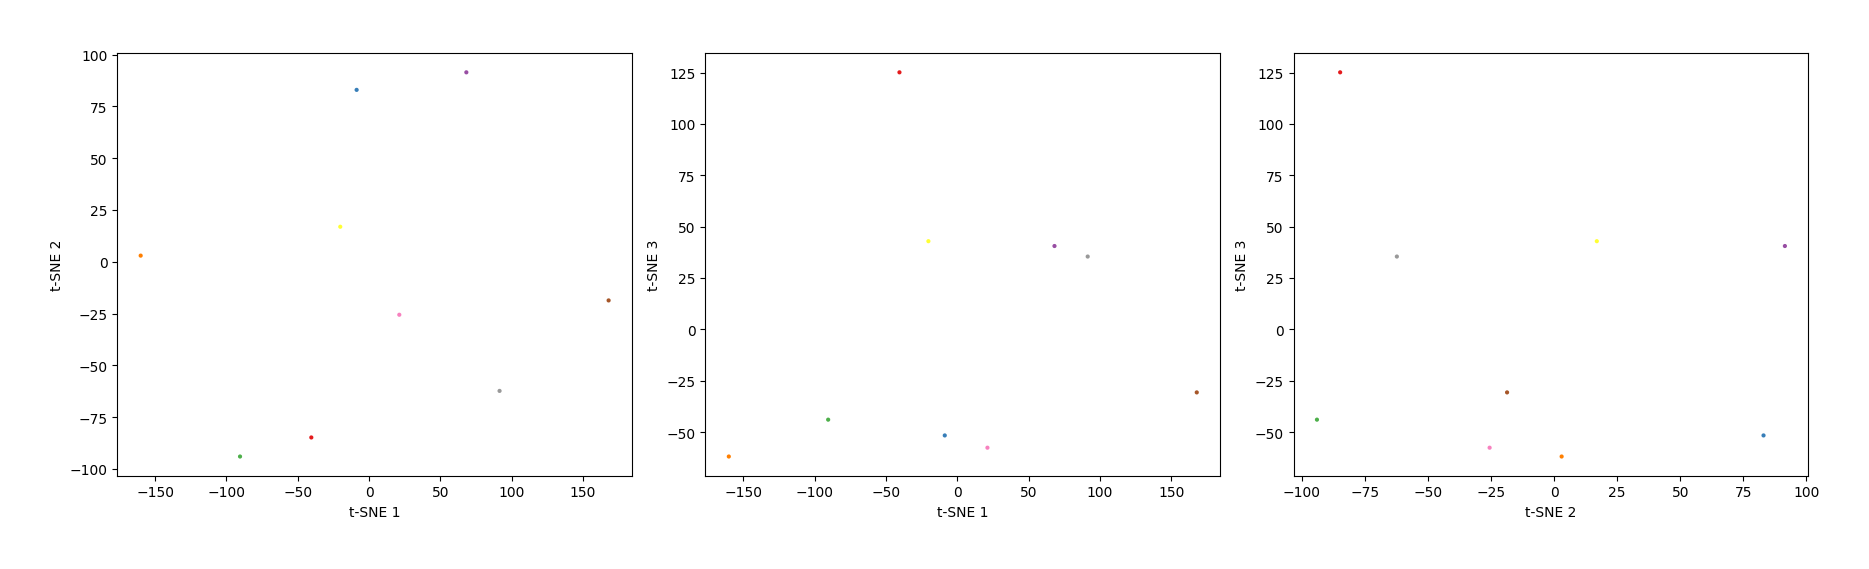

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
projections = [(0,1), (0,2), (1,2)]
for ax, (i,j) in zip(axes, projections):
    ax.scatter(X_tsne[:, i], X_tsne[:, j], c=encoded_labels, cmap='Set1')
    ax.set_xlabel(f"t-SNE {i+1}")
    ax.set_ylabel(f"t-SNE {j+1}")
plt.tight_layout()

# Reactions Analysis

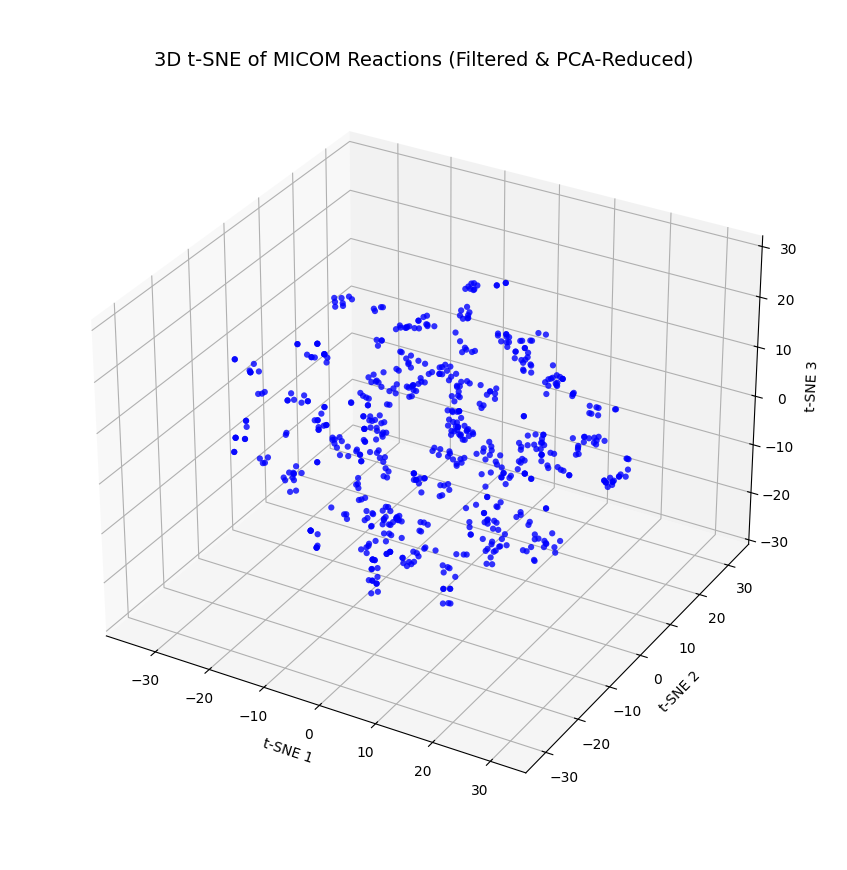

In [ ]:
# Load and clean MICOM flux dataset
df = pd.read_csv("/home/arog/Documents/GitHub/HGMB_Project/comm_results/fluxes_MICOM.csv", sep=";", index_col=0)
df = df.drop(index='medium', errors='ignore')

# Keep only numeric values and transpose
flux_data = df.select_dtypes(include=[np.number]).fillna(0.0)
flux_data_T = flux_data.T  # reactions as rows

# Apply variance filter across strains (axis=0), keeping high-variance reactions
selector = VarianceThreshold(threshold=1e-10)
filtered = selector.fit_transform(flux_data)  # NOT transposed

# Get reaction IDs from columns
filtered_reaction_labels = flux_data.columns[selector.get_support()].to_list()

# Transpose: now rows = reactions
filtered_flux_data = pd.DataFrame(filtered, index=flux_data.index, columns=filtered_reaction_labels).T

# Standardize
X_scaled = StandardScaler().fit_transform(filtered_flux_data)

# PCA
n_pca_components = min(10, X_scaled.shape[1])
X_pca = PCA(n_components=n_pca_components).fit_transform(X_scaled)

# t-SNE
X_tsne = TSNE(n_components=3, perplexity=5, random_state=42).fit_transform(X_pca)

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
                     c='blue', s=20, alpha=0.8)

ax.set_title("3D t-SNE of MICOM Reactions (Filtered & PCA-Reduced)", fontsize=14)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")

plt.tight_layout()
plt.show()



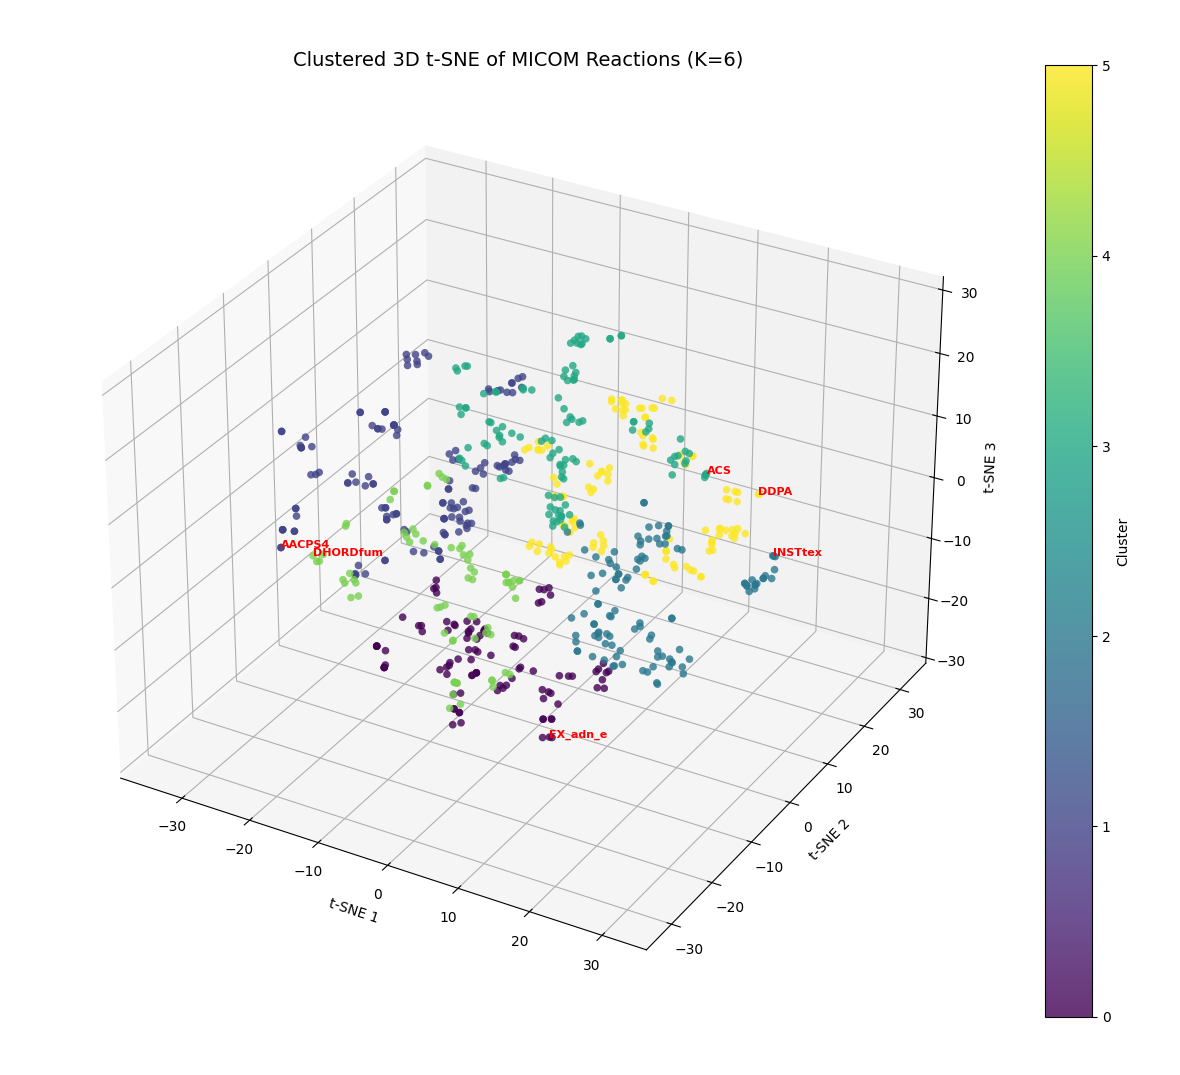

Analysis complete. Results saved to 'clustered_tsne_results.csv'.


In [ ]:

# Optimize cluster number using silhouette score
best_n_clusters = 3
if len(X_tsne) > 2:
    silhouette_scores = []
    for n in range(2, min(10, len(X_tsne))):
        kmeans = KMeans(n_clusters=n, random_state=42).fit(X_tsne)
        score = silhouette_score(X_tsne, kmeans.labels_)
        silhouette_scores.append(score)
    best_n_clusters = np.argmax(silhouette_scores) + 2

kmeans = KMeans(n_clusters=best_n_clusters, random_state=42).fit(X_tsne)
cluster_labels = kmeans.labels_


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
    c=cluster_labels, cmap='viridis', s=30, alpha=0.8, edgecolor='k'
)
ax.set_title(f"Clustered 3D t-SNE of MICOM Reactions (K={best_n_clusters})", fontsize=14)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.colorbar(scatter, label='Cluster')


for cluster_id in range(best_n_clusters):
    cluster_mask = (cluster_labels == cluster_id)
    cluster_points = X_tsne[cluster_mask]
    centroid = kmeans.cluster_centers_[cluster_id]
    

    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    top_reaction_idx = np.argmax(distances)
    

    original_idx = np.where(cluster_mask)[0][top_reaction_idx]
    reaction_id = filtered_reaction_labels[original_idx]
    

    ax.text(
        X_tsne[original_idx, 0], X_tsne[original_idx, 1], X_tsne[original_idx, 2],
        reaction_id, fontsize=8, color='red', weight='bold'
    )

plt.tight_layout()
plt.show()

results_df = pd.DataFrame({
    'Reaction': filtered_reaction_labels,
    'Cluster': cluster_labels,
    'tSNE1': X_tsne[:, 0],
    'tSNE2': X_tsne[:, 1],
    'tSNE3': X_tsne[:, 2]
})
results_df.to_csv("clustered_tsne_results.csv", index=False)